In [1]:
import numpy as np
import pandas as pd
from arch import arch_model
from hurst import compute_Hc
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import MetaTrader5 as mt5
import matplotlib.pyplot  as plt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from sklearn.linear_model import LinearRegression

from scipy.signal import find_peaks
from scipy.interpolate import interp1d


import hurst as hs


In [2]:
def obter_dados(symbol, n_barras=10000):

    # Inicializa o MT5
    if not mt5.initialize():
        print("Falha ao inicializar MT5")
        mt5.shutdown()
    else:
        print("MT5 inicializado com sucesso")

    rates = mt5.copy_rates_from_pos(symbol, mt5.TIMEFRAME_M15, 0, n_barras)
    df = pd.DataFrame(rates)
    df['Date'] = pd.to_datetime(df['time'], unit='s')
    df.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close'}, inplace=True)
    df = df[['Date','Open','High','Low','Close']]
    return df

def calculate_garch_bands(df):
    """
    Calcula bandas GARCH(1,1) SEM lookahead:
    - Retornos logarítmicos
    - Volatilidade GARCH até o final do dia anterior
    - Bandas diárias fixadas em 2 e 4 desvios
    
    Parâmetros:
    df : pd.DataFrame
        DataFrame com colunas 'Date' e 'Close'.
        
    Retorna:
    pd.DataFrame
        DataFrame com colunas adicionais:
        - Log_Returns
        - reference_price
        - daily_vol_garch
        - upper_garch_1d_2d, upper_garch_1d_4d
        - lower_garch_1d_2d, lower_garch_1d_4d
        - garch_mid_d
    """
    
    df = df.copy()
    
    # Converter data e calcular retornos logarítmicos
    df['time'] = pd.to_datetime(df['time'])
    df['Log_Returns'] = np.log(df['close'] / df['close'].shift(1))
    df.dropna(inplace=True)
    df['Day'] = df['time'].dt.to_period('D')
    
    # Lista de dias
    days = sorted(df['Day'].unique())
    
    all_bands = []
    
    for i, day in enumerate(days):
        if i == 0:
            continue  # Primeiro dia não tem referência anterior
        
        # Subconjunto até o final do dia anterior
        subset = df[df['Day'] <= days[i-1]]
        
        # Ajusta GARCH até o dia anterior
        garch_model = arch_model(subset['Log_Returns'] * 100, vol='Garch', p=1, q=1, dist='Normal')
        garch_result = garch_model.fit(disp="off")
        
        # Volatilidade condicional do último candle do dia anterior
        vol_last = garch_result.conditional_volatility.iloc[-1] / 100
        
        # Preço de fechamento do dia anterior
        ref_price = subset[subset['Day'] == days[i-1]]['close'].iloc[-1]
        
        # Cria bandas para todos os candles do dia atual
        day_data = df[df['Day'] == day].copy()
        day_data['reference_price_d'] = ref_price
        day_data['daily_vol_garch'] = vol_last
        
        for d in [2, 4]:
            day_data[f'upper_garch_1d_{d}d'] = (1 + d * vol_last) * ref_price
            day_data[f'lower_garch_1d_{d}d'] = (1 - d * vol_last) * ref_price
        
        day_data['garch_mid_d'] = (day_data['upper_garch_1d_2d'] + day_data['lower_garch_1d_2d']) / 2
        
        all_bands.append(day_data)
    
    # Concatenar resultados
    result = pd.concat(all_bands)
   # result.set_index("time", inplace=True)
    
    return result

def calculate_garch_bands_weekly(df):
    """
    Calcula bandas GARCH(1,1) SEM lookahead:
    - Retornos logarítmicos
    - Volatilidade GARCH até o final da semana anterior
    - Bandas semanais fixadas em 2 e 4 desvios
    
    Parâmetros:
    df : pd.DataFrame
        DataFrame com colunas 'Date' e 'Close'.
        
    Retorna:
    pd.DataFrame
        DataFrame com colunas adicionais:
        - Log_Returns
        - reference_price
        - weekly_vol_garch
        - upper_garch_1w_2d, upper_garch_1w_4d
        - lower_garch_1w_2d, lower_garch_1w_4d
        - garch_mid_w
    """
    df = df.copy()
    
    # Converter datas e calcular retornos
    df['time'] = pd.to_datetime(df['time'])
    df['Log_Returns'] = np.log(df['close'] / df['close'].shift(1))
    df.dropna(inplace=True)
    df['Week'] = df['time'].dt.to_period('W')  # Agrupamento semanal
    
    # Lista de semanas
    weeks = sorted(df['Week'].unique())
    
    all_bands = []
    
    for i, week in enumerate(weeks):
        if i == 0:
            continue  # Primeira semana não tem referência anterior
        
        # Subconjunto até o fim da semana anterior
        subset = df[df['Week'] <= weeks[i-1]]
        
        # Ajusta GARCH até semana anterior
        garch_model = arch_model(subset['Log_Returns'] * 100, vol='Garch', p=1, q=1, dist='Normal')
        garch_result = garch_model.fit(disp="off")
        
        # Volatilidade condicional do último candle da semana anterior
        vol_last = garch_result.conditional_volatility.iloc[-1] / 100
        
        # Preço de fechamento do último candle da semana anterior
        ref_price = subset[subset['Week'] == weeks[i-1]]['close'].iloc[-1]
        
        # Cria bandas para todos os candles da semana atual
        week_data = df[df['Week'] == week].copy()
        week_data['reference_price_w'] = ref_price
        week_data['weekly_vol_garch'] = vol_last
        
        for d in [2, 4, 6]:
            week_data[f'upper_garch_1w_{d}d'] = (1 + d * vol_last) * ref_price
            week_data[f'lower_garch_1w_{d}d'] = (1 - d * vol_last) * ref_price
        
        week_data['garch_mid_w'] = (week_data['upper_garch_1w_2d'] + week_data['lower_garch_1w_2d']) / 2
        
        all_bands.append(week_data)
    
    # Concatenar resultados
    result = pd.concat(all_bands)    
    return result

def Calculate_Hurst(df, var, window_size, ser_type):
    """
    Calculates the hurst exponent for the var:variable in df:dataset for given rolling window size
    ser_type: gives the type of series. It can be of three types:
        'change':      a series is just random values (i.e. np.random.randn(...))
        'random_walk': a series is a cumulative sum of changes (i.e. np.cumsum(np.random.randn(...)))
        'price':       a series is a cumulative product of changes (i.e. np.cumprod(1+epsilon*np.random.randn(...))
    """
    hurst = [np.nan] * (window_size-1)
    var_values = list(df[var])
    for i in range(0, len(var_values)-(window_size-1)):
        H, c, data = hs.compute_Hc(var_values[i:i+window_size], kind=ser_type, simplified=True)
        hurst.append(H)
    df['hurst_'+str(window_size)] = hurst
    return df

In [3]:
df_all = pd.read_csv('datasets/df_all.csv')
df_all = df_all.rename(columns={"Date": "time"})
df_all['time'] = pd.to_datetime(df_all['time'])

In [4]:
df_all.ticker.unique()

array(['ABEV3', 'ASAI3', 'B3SA3', 'BBSE3', 'BBDC3', 'BBDC4', 'BBAS3',
       'BRAV3', 'BPAC11', 'CMIG4', 'COGN3', 'CPLE6', 'CSAN3', 'CYRE3',
       'ELET3', 'EMBR3', 'ENGI11', 'ENEV3', 'EQTL3', 'GGBR4', 'HAPV3',
       'HYPE3', 'ITSA4', 'ITUB4', 'KLBN11', 'RENT3', 'LREN3', 'MGLU3',
       'POMO4', 'MBRF3', 'MOTV3', 'MULT3', 'NATU3', 'PETR3', 'PETR4',
       'PRIO3', 'RADL3', 'RDOR3', 'RAIL3', 'SBSP3', 'CSNA3', 'SUZB3',
       'VIVT3', 'TIMS3', 'TOTS3', 'UGPA3', 'VALE3', 'VBBR3', 'WEGE3'],
      dtype=object)

In [5]:
tickers = ['ABEV3','ELET3','BBAS3','CMIG4','CPLE6','CYRE3','EMBR3','GGBR4','ITSA4','VALE3','VIVT3','PETR4']


In [6]:
df1 = df_all[df_all["ticker"] == "PETR4"]
df1 = df1.dropna()
df1.drop('ticker',axis=1,inplace=True)
df1.reset_index(drop=True, inplace=True)
df1

time       open       high        low      close        volume
0    2000-01-03   1.309279   1.309279   1.309279   1.309279  3.538944e+10
1    2000-01-04   1.236851   1.236851   1.236851   1.236851  2.886144e+10
2    2000-01-05   1.224371   1.224371   1.224371   1.224371  4.303360e+10
3    2000-01-06   1.220137   1.220137   1.220137   1.220137  3.405568e+10
4    2000-01-07   1.225708   1.225708   1.225708   1.225708  2.091264e+10
...         ...        ...        ...        ...        ...           ...
6462 2025-09-26  32.490002  32.740002  32.150002  32.250000  2.781970e+07
6463 2025-09-29  32.259998  32.540001  31.730000  31.809999  3.572000e+07
6464 2025-09-30  31.690001  31.900000  31.160000  31.459999  4.861150e+07
6465 2025-10-01  31.450001  31.549999  31.299999  31.379999  2.481700e+07
6466 2025-10-02  31.379999  31.410000  31.110001  31.110001  5.997200e+06

[6467 rows x 6 columns]

In [7]:
'''df1 = pd.read_csv('datasets/BTCUSDT_1D_BINANCE_FUTURES.csv')
df1.drop(['Unnamed: 0', 'close_time', 'open_time'], axis=1, inplace=True)
df1.time = pd.to_datetime(df1.time)'''

"df1 = pd.read_csv('datasets/BTCUSDT_1D_BINANCE_FUTURES.csv')\ndf1.drop(['Unnamed: 0', 'close_time', 'open_time'], axis=1, inplace=True)\ndf1.time = pd.to_datetime(df1.time)"

## Target

In [8]:
df = df1.copy()
#df = df.tail(1000)
df.reset_index(drop=True, inplace=True)

In [9]:
df

time       open       high        low      close        volume
0    2000-01-03   1.309279   1.309279   1.309279   1.309279  3.538944e+10
1    2000-01-04   1.236851   1.236851   1.236851   1.236851  2.886144e+10
2    2000-01-05   1.224371   1.224371   1.224371   1.224371  4.303360e+10
3    2000-01-06   1.220137   1.220137   1.220137   1.220137  3.405568e+10
4    2000-01-07   1.225708   1.225708   1.225708   1.225708  2.091264e+10
...         ...        ...        ...        ...        ...           ...
6462 2025-09-26  32.490002  32.740002  32.150002  32.250000  2.781970e+07
6463 2025-09-29  32.259998  32.540001  31.730000  31.809999  3.572000e+07
6464 2025-09-30  31.690001  31.900000  31.160000  31.459999  4.861150e+07
6465 2025-10-01  31.450001  31.549999  31.299999  31.379999  2.481700e+07
6466 2025-10-02  31.379999  31.410000  31.110001  31.110001  5.997200e+06

[6467 rows x 6 columns]

In [10]:
peak_value = 1
threshold_pct = 1

peak_value_ = 30
threshold_pct_ = 1

In [11]:
# --- FUNÇÃO PARA CALCULAR TARGET ---
def compute_target(df, peak_value, threshold_pct):
    df = df.copy()
    
    # Inicializa colunas temporárias
    df['peaks_temp'] = np.nan
    df['troughs_temp'] = np.nan
    
    # Identificar topos e fundos
    peaks, _ = find_peaks(df['close'], distance=peak_value)
    troughs, _ = find_peaks(-df['close'], distance=peak_value)
    
    # Preencher valores reais
    df.loc[peaks, 'peaks_temp'] = df['close'].iloc[peaks]
    df.loc[troughs, 'troughs_temp'] = df['close'].iloc[troughs]
    
    # Interpolação linear
    if len(peaks) > 1:
        f_peaks = interp1d(peaks, df['close'].iloc[peaks], kind='linear', fill_value="extrapolate")
        df['peaks_temp'] = f_peaks(np.arange(len(df)))
    else:
        df['peaks_temp'] = df['close'].iloc[peaks[0]]
    
    if len(troughs) > 1:
        f_troughs = interp1d(troughs, df['close'].iloc[troughs], kind='linear', fill_value="extrapolate")
        df['troughs_temp'] = f_troughs(np.arange(len(df)))
    else:
        df['troughs_temp'] = df['close'].iloc[troughs[0]]
    
    # Inclinação
    pct_peaks = df['peaks_temp'].pct_change() * 10000
    pct_troughs = df['troughs_temp'].pct_change() * 10000
    
    # Target
    target = np.where(
        (pct_peaks >= threshold_pct) & (pct_troughs >= threshold_pct),
        1,
        np.where(
            (pct_peaks <= -threshold_pct) & (pct_troughs <= -threshold_pct),
            -1,
            0
        )
    )
    
    return target

# --- CRIAR target_ (original) ---
df['target_'] = compute_target(df, peak_value, threshold_pct)

# --- CRIAR target_1 (com novos parâmetros) ---
df['target_1'] = compute_target(df, peak_value_, threshold_pct_)

# --- CRIAR TARGET FINAL ---
def combine_targets(t1, t2):
    combined = []
    for a, b in zip(t1, t2):
        # Se ambos iguais
        if a == b:
            combined.append(a)
        # Se um é 1 e o outro 0 ou vice-versa
        elif (a == 1 and b == 0) or (a == 0 and b == 1):
            combined.append(1)
        elif (a == -1 and b == 0) or (a == 0 and b == -1):
            combined.append(-1)
        # Se conflitantes 1 e -1, predomina target_
        else:
            combined.append(a)
    return combined

df['target'] = combine_targets(df['target_'], df['target_1'])

In [12]:
import plotly.graph_objects as go
import numpy as np
df.set_index('time',inplace=True)
fig = go.Figure()

# Inicializar arrays
targets = df['target'].values
start_idx = 0

# Criar segmentos contínuos de cores
for i in range(1, len(targets)):
    if targets[i] != targets[start_idx]:
        # Determinar cor do segmento
        color = 'black'  # neutro
        if targets[start_idx] == 1:
            color = 'green'
        elif targets[start_idx] == -1:
            color = 'red'
        
        fig.add_trace(go.Scatter(
            x=df.index[start_idx:i],
            y=df['close'].iloc[start_idx:i],
            mode='lines',
            line=dict(color=color),
            showlegend=False
        ))
        start_idx = i

# Último segmento
color = 'black'
if targets[start_idx] == 1:
    color = 'green'
elif targets[start_idx] == -1:
    color = 'red'

fig.add_trace(go.Scatter(
    x=df.index[start_idx:],
    y=df['close'].iloc[start_idx:],
    mode='lines',
    line=dict(color=color),
    showlegend=False
))

# Layout
fig.update_layout(
    title="WINFUT Close Price",
    xaxis_title="Tempo",
    yaxis_title="Preço",
    template="plotly_white",
    hovermode="x unified",
    height=600
)

fig.show()
df.reset_index(inplace=True)

In [13]:
df.drop(['target_', 'target_1'], axis=1, inplace=True)

In [14]:
df2 = df.copy()

## Features

In [15]:
df = df2.copy()
'''df.drop('peaks', axis=1, inplace=True)
df.drop('troughs', axis=1, inplace=True)
df.drop('pct_peaks', axis=1, inplace=True)
df.drop('pct_troughs', axis=1, inplace=True)'''

"df.drop('peaks', axis=1, inplace=True)\ndf.drop('troughs', axis=1, inplace=True)\ndf.drop('pct_peaks', axis=1, inplace=True)\ndf.drop('pct_troughs', axis=1, inplace=True)"

In [16]:
# AVAT
df['return'] = df['close'].pct_change()

# Média móvel do volume
df['AvgVolume'] = df['volume'].rolling(window=20).mean()

# AVAT = Volume atual / Média móvel do volume
df['AVAT'] = df['volume'] / df['AvgVolume']

In [17]:
# GARCH 
df = calculate_garch_bands_weekly(df)

df.drop('Week', axis=1,inplace=True)

# (Close - garch mid) / (close - ref_price)
df['distance_w'] =  (df.close - df.garch_mid_w) / df.garch_mid_w

df['distance_w_17_mean'] = df.distance_w.rolling(17).mean()
df['distance_w_72_mean'] = df.distance_w.rolling(72).mean()

c:\Users\rodrigo\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\volatility.py:1215: RuntimeWarning:

invalid value encountered in scalar divide

c:\Users\rodrigo\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\distribution.py:449: RuntimeWarning:

divide by zero encountered in log

c:\Users\rodrigo\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\distribution.py:449: RuntimeWarning:

invalid value encountered in divide

c:\Users\rodrigo\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\distribution.py:449: RuntimeWarning:

divide by zero encountered in divide

c:\Users\rodrigo\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\distribution.py:449: RuntimeWarning:

invalid value encountered in add

c:\Users\rodrigo\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning:

The optimizer returned code 4. The message 

In [18]:
# HURST
hurst_windows = [100, 150, 200, 250, 300, 400]

# Calculate hurst exponents for given window sizes
for i in range(0, len(hurst_windows)):
    df = Calculate_Hurst(df, 'close', hurst_windows[i], 'price')

In [19]:
df3 = df.copy()

## Modeling

In [20]:
# === 1. Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import xgboost as xgb

In [21]:
df = df3.copy()
#df.set_index('time', inplace=True)

#### Division data

In [22]:
df = df.iloc[400:]
df['target'] = df['target'].replace(-1, 2)

#X = df.drop(columns=['target', 'time'], errors='ignore').select_dtypes(include=['number'])
#y = df['target']

In [23]:
df

time       open       high        low      close      volume  \
420  2001-08-13   1.481714   1.490350   1.476421   1.479207  21443200.0   
421  2001-08-14   1.458314   1.504278   1.458314   1.498707  26512000.0   
422  2001-08-15   1.504278   1.523778   1.491186   1.512914  42790400.0   
423  2001-08-16   1.501493   1.523778   1.498707   1.512357  24953600.0   
424  2001-08-17   1.484779   1.515143   1.454972   1.465279  36291200.0   
...         ...        ...        ...        ...        ...         ...   
6462 2025-09-26  32.490002  32.740002  32.150002  32.250000  27819700.0   
6463 2025-09-29  32.259998  32.540001  31.730000  31.809999  35720000.0   
6464 2025-09-30  31.690001  31.900000  31.160000  31.459999  48611500.0   
6465 2025-10-01  31.450001  31.549999  31.299999  31.379999  24817000.0   
6466 2025-10-02  31.379999  31.410000  31.110001  31.110001   5997200.0   

      target    return   AvgVolume      AVAT  ...  garch_mid_w  distance_w  \
420        1 -0.005432  35297760.0  0.607495  ...     1.487285   -0.005432   
421        0  0.013183  32719040.0  0.810293  ...     1.487285    0.007679   
422        0  0.009480  29936640.0  1.429365  ...     1.487285    0.017232   
423        2 -0.000368  25867840.0  0.964657  ...     1.487285    0.016857   
424        2 -0.031129  26335520.0  1.378032  ...     1.487285   -0.014797   
...      ...       ...         ...       ...  ...          ...         ...   
6462       0 -0.003399  27665505.0  1.005574  ...    31.059999    0.038313   
6463       0 -0.013643  28957020.0  1.233552  ...    32.250000   -0.013643   
6464       0 -0.011003  30396995.0  1.599221  ...    32.250000   -0.024496   
6465       0 -0.002543  30148405.0  0.823161  ...    32.250000   -0.026977   
6466       0 -0.008604  29207440.0  0.205331  ...    32.250000   -0.035349   

      distance_w_17_mean  distance_w_72_mean  hurst_100  hurst_150  hurst_200  \
420             0.002474           -0.003079   0.691893   0.594521   0.527948   
421             0.003800           -0.003492   0.699751   0.606643   0.518518   
422             0.003649           -0.002827   0.694132   0.589557   0.504956   
423             0.004085           -0.002218   0.720414   0.603710   0.499791   
424             0.001994           -0.002048   0.767955   0.602856   0.499238   
...                  ...                 ...        ...        ...        ...   
6462            0.016569            0.004363   0.417472   0.493989   0.480882   
6463            0.015842            0.004012   0.402420   0.456329   0.462772   
6464            0.015366            0.003548   0.401030   0.452355   0.467662   
6465            0.013548            0.003520   0.437186   0.463438   0.489976   
6466            0.010776            0.003643   0.435335   0.483983   0.513982   

      hurst_250  hurst_300  hurst_400  
420    0.463360   0.412921   0.438733  
421    0.461026   0.395944   0.441106  
422    0.442291   0.386301   0.440695  
423    0.452715   0.403692   0.449207  
424    0.457388   0.419860   0.442800  
...         ...        ...        ...  
6462   0.456964   0.415465   0.431132  
6463   0.452600   0.408956   0.421556  
6464   0.464863   0.421134   0.432031  
6465   0.487951   0.434726   0.439680  
6466   0.496306   0.438868   0.445009  

[6047 rows x 29 columns]

In [24]:
feature_cols = ['open', 'high', 'low', 'close', 'volume', 'return', 'AvgVolume', 'AVAT', 'Log_Returns',
                'reference_price_w', 'weekly_vol_garch', 'upper_garch_1w_2d', 'lower_garch_1w_2d', 
                'upper_garch_1w_4d', 'lower_garch_1w_4d', 'garch_mid_w', 'distance_w', 'distance_w_17_mean', 
                'distance_w_72_mean', 'hurst_100', 'hurst_150', 'hurst_200', 'hurst_250', 'hurst_300', 'hurst_400']


In [25]:
# Division
df['time'] = pd.to_datetime(df['time'])

# === 2. Split temporal ===
train_mask = (df['time'] >= '2000-01-01') & (df['time'] <= '2022-12-31')
test_mask  = (df['time'] >= '2023-01-01') & (df['time'] <= '2025-12-31')

df_train = df.loc[train_mask].copy().reset_index(drop=True)
df_test  = df.loc[test_mask].copy().reset_index(drop=True)

# === 3. Features e Target ===
X_train = df_train[feature_cols]
y_train = df_train['target']

X_test  = df_test[feature_cols]
y_test  = df_test['target']

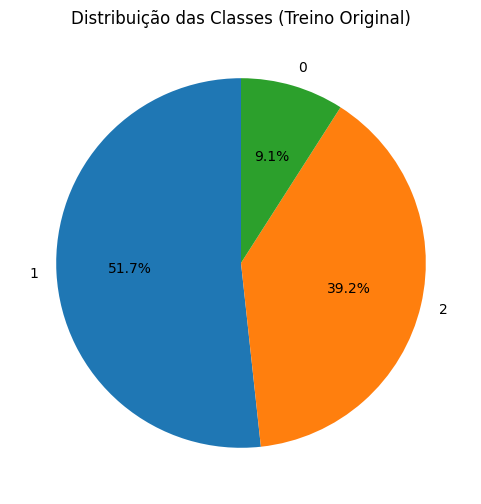

In [26]:
plt.figure(figsize=(6,6))
plt.pie(y_train.value_counts(), labels=y_train.value_counts().index, autopct='%1.1f%%', startangle=90)
plt.title("Distribuição das Classes (Treino Original)")
plt.show()

#### XGBoost

In [27]:
class_weights = {0: 1, 1: 1, 2: 1}

c:\Users\rodrigo\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning:

[01:23:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




=== Relatório de Classificação ===
              precision    recall  f1-score   support

           0       0.32      0.08      0.13        73
           1       0.75      0.70      0.72       383
           2       0.53      0.71      0.60       233

    accuracy                           0.64       689
   macro avg       0.53      0.50      0.49       689
weighted avg       0.63      0.64      0.62       689



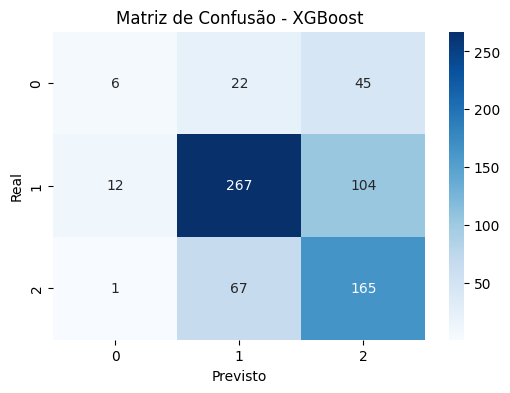

In [28]:
# === 4. Pesos das classes ===
classes = np.unique(y_train)

# Exemplo de pesos (ajuste conforme necessidade)

sample_weights = np.array([class_weights[y] for y in y_train])

# === 5. Modelo XGBoost ===
model = xgb.XGBClassifier(
    objective="multi:softmax",
    num_class=3,
    eval_metric="mlogloss",
    use_label_encoder=False,
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Treinar modelo
model.fit(X_train, y_train, sample_weight=sample_weights)

# Previsões
df_test['pred'] = model.predict(X_test)

# === 6. Avaliação ===
print("=== Relatório de Classificação ===")
print(classification_report(df_test['target'], df_test['pred']))

cm = confusion_matrix(df_test['target'], df_test['pred'])

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1,2], yticklabels=[0,1,2])
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.title("Matriz de Confusão - XGBoost")
plt.show()

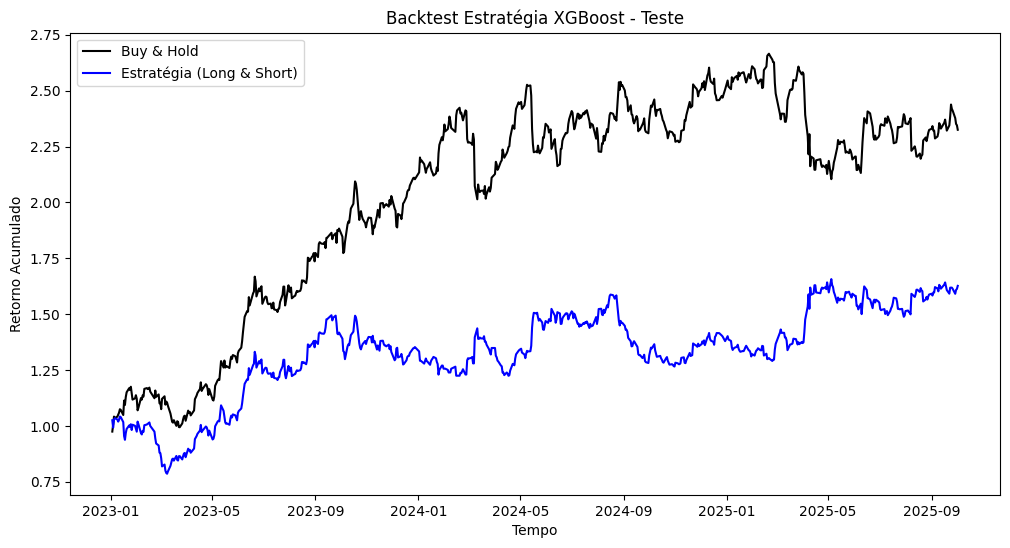

Retorno total da estratégia: 62.67%
Sharpe ratio aproximado: 0.79
Taxa de acerto (dias positivos): 48.77%


In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Garantir que preços estão ordenados por tempo
df_test = df_test.sort_values('time').reset_index(drop=True)

# Calcular retornos do ativo
df_test['returns'] = df_test['close'].pct_change()

# Definir posição da estratégia
df_test['position'] = 0
df_test.loc[df_test['pred'] == 1, 'position'] = 1   # Long
df_test.loc[df_test['pred'] == 2, 'position'] = -1  # Short

# Evitar lookahead bias (shift para só operar no próximo dia)
df_test['position'] = df_test['position'].shift(1).fillna(0)

# Retorno da estratégia
df_test['strategy_return'] = df_test['position'] * df_test['returns']

# Retornos acumulados
df_test['cum_asset'] = (1 + df_test['returns']).cumprod()
df_test['cum_strategy'] = (1 + df_test['strategy_return']).cumprod()

# === Plot Backtest ===
plt.figure(figsize=(12,6))
plt.plot(df_test['time'], df_test['cum_asset'], label='Buy & Hold', color='black')
plt.plot(df_test['time'], df_test['cum_strategy'], label='Estratégia (Long & Short)', color='blue')
plt.title("Backtest Estratégia XGBoost - Teste")
plt.xlabel("Tempo")
plt.ylabel("Retorno Acumulado")
plt.legend()
plt.show()

# === Métricas ===
total_return = df_test['cum_strategy'].iloc[-1] - 1
sharpe_ratio = df_test['strategy_return'].mean() / df_test['strategy_return'].std() * np.sqrt(252)
hit_ratio = (df_test['strategy_return'] > 0).mean()

print(f"Retorno total da estratégia: {total_return:.2%}")
print(f"Sharpe ratio aproximado: {sharpe_ratio:.2f}")
print(f"Taxa de acerto (dias positivos): {hit_ratio:.2%}")


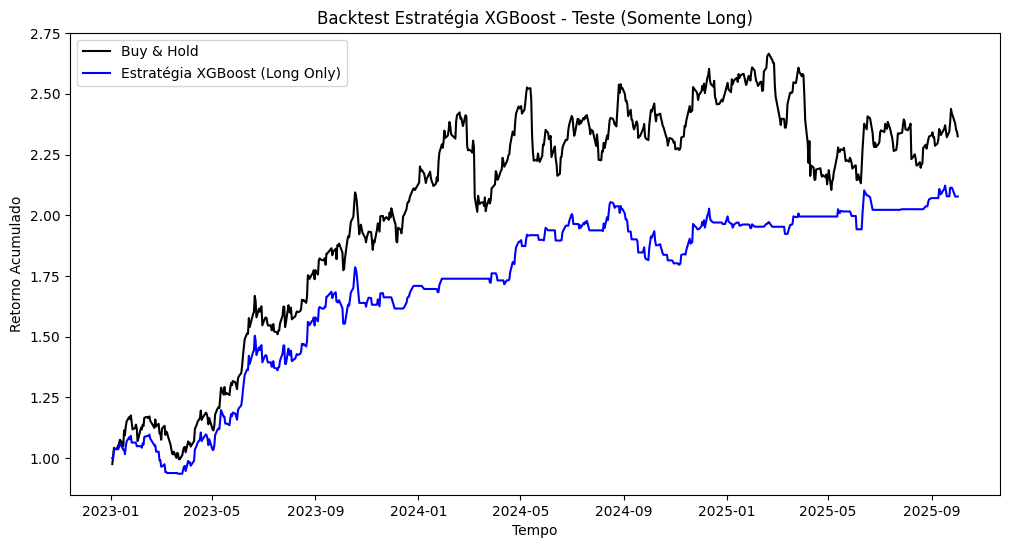

Retorno total da estratégia: 107.71%
Sharpe ratio aproximado: 1.50
Taxa de acerto (dias positivos): 27.87%


In [30]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Garantir ordenação temporal
df_test = df_test.sort_values('time').reset_index(drop=True)

# Calcular retorno diário do ativo
df_test['returns'] = df_test['close'].pct_change()

# Definir posição da estratégia (Long Only: pred == 1)
df_test['position'] = 0
df_test.loc[df_test['pred'] == 1, 'position'] = 1   # Long
# Evitar lookahead bias
df_test['position'] = df_test['position'].shift(1).fillna(0)

# Retorno da estratégia
df_test['strategy_return'] = df_test['position'] * df_test['returns']

# Retornos acumulados
df_test['cum_asset'] = (1 + df_test['returns']).cumprod()
df_test['cum_strategy'] = (1 + df_test['strategy_return']).cumprod()

# Plot do backtest
plt.figure(figsize=(12,6))
plt.plot(df_test['time'], df_test['cum_asset'], label='Buy & Hold', color='black')
plt.plot(df_test['time'], df_test['cum_strategy'], label='Estratégia XGBoost (Long Only)', color='blue')
plt.title("Backtest Estratégia XGBoost - Teste (Somente Long)")
plt.xlabel("Tempo")
plt.ylabel("Retorno Acumulado")
plt.legend()
plt.show()

# Métricas de performance
total_return = df_test['cum_strategy'].iloc[-1] - 1
sharpe_ratio = df_test['strategy_return'].mean() / df_test['strategy_return'].std() * np.sqrt(252)
hit_ratio = (df_test['strategy_return'] > 0).mean()

print(f"Retorno total da estratégia: {total_return:.2%}")
print(f"Sharpe ratio aproximado: {sharpe_ratio:.2f}")
print(f"Taxa de acerto (dias positivos): {hit_ratio:.2%}")


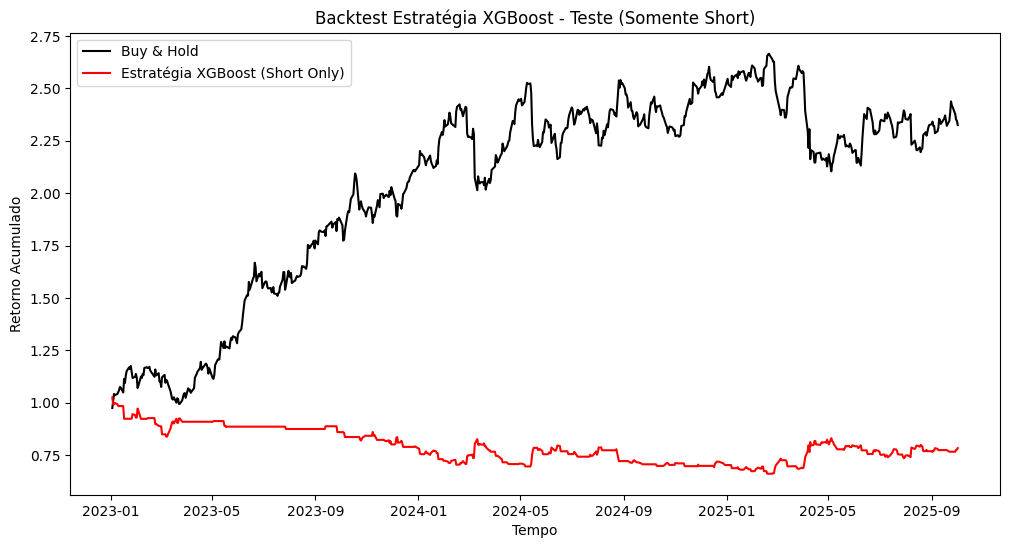

Retorno total da estratégia: -21.68%
Sharpe ratio aproximado: -0.36
Taxa de acerto (dias positivos): 20.90%


In [31]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Garantir ordenação temporal
df_test = df_test.sort_values('time').reset_index(drop=True)

# Calcular retorno diário do ativo
df_test['returns'] = df_test['close'].pct_change()

# Definir posição da estratégia (Short Only: pred == 2)
df_test['position'] = 0
df_test.loc[df_test['pred'] == 2, 'position'] = -1   # Short
# Evitar lookahead bias
df_test['position'] = df_test['position'].shift(1).fillna(0)

# Retorno da estratégia
df_test['strategy_return'] = df_test['position'] * df_test['returns']

# Retornos acumulados
df_test['cum_asset'] = (1 + df_test['returns']).cumprod()
df_test['cum_strategy'] = (1 + df_test['strategy_return']).cumprod()

# Plot do backtest
plt.figure(figsize=(12,6))
plt.plot(df_test['time'], df_test['cum_asset'], label='Buy & Hold', color='black')
plt.plot(df_test['time'], df_test['cum_strategy'], label='Estratégia XGBoost (Short Only)', color='red')
plt.title("Backtest Estratégia XGBoost - Teste (Somente Short)")
plt.xlabel("Tempo")
plt.ylabel("Retorno Acumulado")
plt.legend()
plt.show()

# Métricas de performance
total_return = df_test['cum_strategy'].iloc[-1] - 1
sharpe_ratio = df_test['strategy_return'].mean() / df_test['strategy_return'].std() * np.sqrt(252)
hit_ratio = (df_test['strategy_return'] > 0).mean()

print(f"Retorno total da estratégia: {total_return:.2%}")
print(f"Sharpe ratio aproximado: {sharpe_ratio:.2f}")
print(f"Taxa de acerto (dias positivos): {hit_ratio:.2%}")


In [32]:
class_weights = {0: 1, 1: 1, 2: 1}

c:\Users\rodrigo\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning:

[01:23:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.




=== Relatório de Classificação ===
              precision    recall  f1-score   support

           0       0.50      0.03      0.05        73
           1       0.79      0.72      0.75       383
           2       0.53      0.76      0.62       233

    accuracy                           0.66       689
   macro avg       0.60      0.50      0.48       689
weighted avg       0.67      0.66      0.63       689



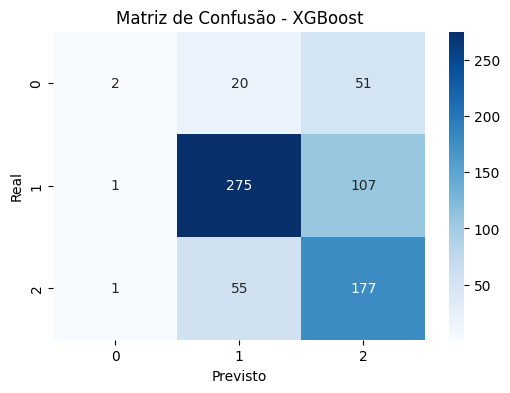

In [33]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Classes únicas
classes = np.unique(y_train)

# Pesos manuais
sample_weights = np.array([class_weights[y] for y in y_train])

# Criar modelo XGBoost com hiperparâmetros adicionais
model = xgb.XGBClassifier(
    objective="multi:softmax",
    num_class=3,
    eval_metric="mlogloss",
    use_label_encoder=False,
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    min_child_weight=10,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=1,
    reg_alpha=0.1,
    reg_lambda=0.01,
    random_state=42
)

# Treinar modelo
model.fit(X_train, y_train, sample_weight=sample_weights)

# Prever no teste
y_pred = model.predict(X_test)

# Adicionar previsões no df_test
df_test['pred'] = y_pred

# === Avaliação ===
print("=== Relatório de Classificação ===")
print(classification_report(y_test, y_pred))

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1,2], yticklabels=[0,1,2])
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.title("Matriz de Confusão - XGBoost")
plt.show()


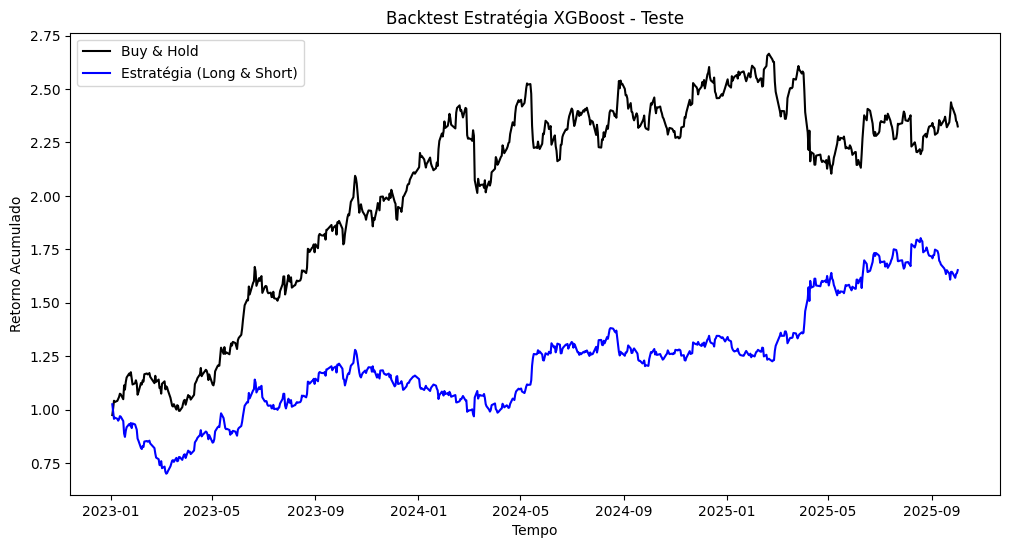

Retorno total da estratégia: 65.29%
Sharpe ratio aproximado: 0.81
Taxa de acerto: 51.09%


In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Garantir que preços estão ordenados por tempo
df_test = df_test.sort_values('time').reset_index(drop=True)

# Calcular retornos do ativo
df_test['returns'] = df_test['close'].pct_change()

# Definir posição da estratégia
df_test['position'] = 0
df_test.loc[df_test['pred'] == 1, 'position'] = 1   # Long
df_test.loc[df_test['pred'] == 2, 'position'] = -1  # Short

# Evitar lookahead bias (shift para só operar no próximo dia)
df_test['position'] = df_test['position'].shift(1).fillna(0)

# Retorno da estratégia
df_test['strategy_return'] = df_test['position'] * df_test['returns']

# Retornos acumulados
df_test['cum_asset'] = (1 + df_test['returns']).cumprod()
df_test['cum_strategy'] = (1 + df_test['strategy_return']).cumprod()

# === Plot Backtest ===
plt.figure(figsize=(12,6))
plt.plot(df_test['time'], df_test['cum_asset'], label='Buy & Hold', color='black')
plt.plot(df_test['time'], df_test['cum_strategy'], label='Estratégia (Long & Short)', color='blue')
plt.title("Backtest Estratégia XGBoost - Teste")
plt.xlabel("Tempo")
plt.ylabel("Retorno Acumulado")
plt.legend()
plt.show()

# === Métricas ===
total_return = df_test['cum_strategy'].iloc[-1] - 1
sharpe_ratio = df_test['strategy_return'].mean() / df_test['strategy_return'].std() * np.sqrt(252)
hit_ratio = (df_test['strategy_return'] > 0).mean()

print(f"Retorno total da estratégia: {total_return:.2%}")
print(f"Sharpe ratio aproximado: {sharpe_ratio:.2f}")
print(f"Taxa de acerto: {hit_ratio:.2%}")


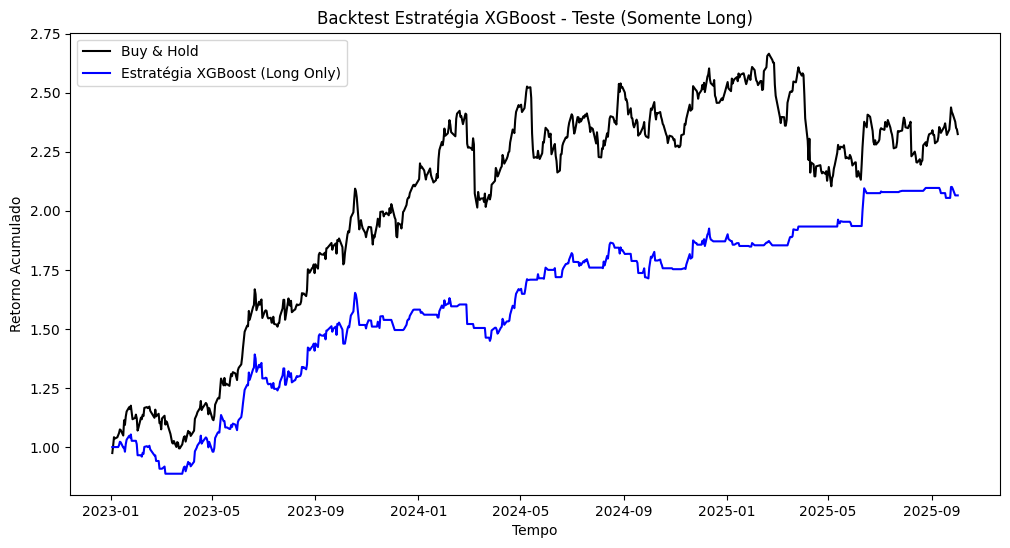

Retorno total da estratégia: 106.54%
Sharpe ratio aproximado: 1.47
Taxa de acerto: 27.87%


In [35]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Garantir ordenação temporal
df_test = df_test.sort_values('time').reset_index(drop=True)

# Calcular retorno diário do ativo
df_test['returns'] = df_test['close'].pct_change()

# Definir posição da estratégia (Long Only: pred == 1)
df_test['position'] = 0
df_test.loc[df_test['pred'] == 1, 'position'] = 1   # Long
# Evitar lookahead bias
df_test['position'] = df_test['position'].shift(1).fillna(0)

# Retorno da estratégia
df_test['strategy_return'] = df_test['position'] * df_test['returns']

# Retornos acumulados
df_test['cum_asset'] = (1 + df_test['returns']).cumprod()
df_test['cum_strategy'] = (1 + df_test['strategy_return']).cumprod()

# Plot do backtest
plt.figure(figsize=(12,6))
plt.plot(df_test['time'], df_test['cum_asset'], label='Buy & Hold', color='black')
plt.plot(df_test['time'], df_test['cum_strategy'], label='Estratégia XGBoost (Long Only)', color='blue')
plt.title("Backtest Estratégia XGBoost - Teste (Somente Long)")
plt.xlabel("Tempo")
plt.ylabel("Retorno Acumulado")
plt.legend()
plt.show()

# Métricas de performance
total_return = df_test['cum_strategy'].iloc[-1] - 1
sharpe_ratio = df_test['strategy_return'].mean() / df_test['strategy_return'].std() * np.sqrt(252)
hit_ratio = (df_test['strategy_return'] > 0).mean()

print(f"Retorno total da estratégia: {total_return:.2%}")
print(f"Sharpe ratio aproximado: {sharpe_ratio:.2f}")
print(f"Taxa de acerto: {hit_ratio:.2%}")


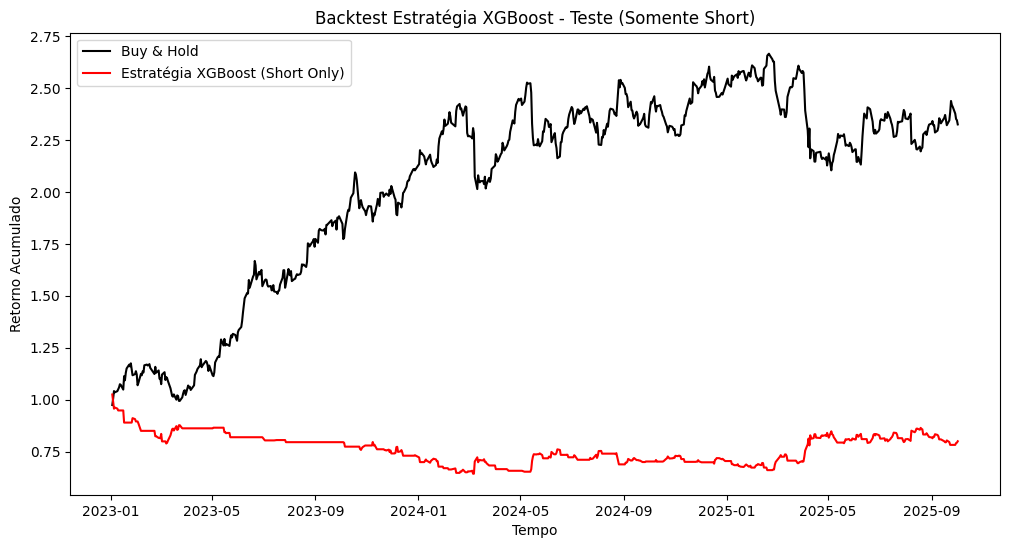

Retorno total da estratégia: -19.97%
Sharpe ratio aproximado: -0.32
Taxa de acerto: 23.22%


In [36]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Garantir ordenação temporal
df_test = df_test.sort_values('time').reset_index(drop=True)

# Calcular retorno diário do ativo
df_test['returns'] = df_test['close'].pct_change()

# Definir posição da estratégia (Short Only: pred == 2)
df_test['position'] = 0
df_test.loc[df_test['pred'] == 2, 'position'] = -1   # Short
# Evitar lookahead bias
df_test['position'] = df_test['position'].shift(1).fillna(0)

# Retorno da estratégia
df_test['strategy_return'] = df_test['position'] * df_test['returns']

# Retornos acumulados
df_test['cum_asset'] = (1 + df_test['returns']).cumprod()
df_test['cum_strategy'] = (1 + df_test['strategy_return']).cumprod()

# Plot do backtest
plt.figure(figsize=(12,6))
plt.plot(df_test['time'], df_test['cum_asset'], label='Buy & Hold', color='black')
plt.plot(df_test['time'], df_test['cum_strategy'], label='Estratégia XGBoost (Short Only)', color='red')
plt.title("Backtest Estratégia XGBoost - Teste (Somente Short)")
plt.xlabel("Tempo")
plt.ylabel("Retorno Acumulado")
plt.legend()
plt.show()

# Métricas de performance
total_return = df_test['cum_strategy'].iloc[-1] - 1
sharpe_ratio = df_test['strategy_return'].mean() / df_test['strategy_return'].std() * np.sqrt(252)
hit_ratio = (df_test['strategy_return'] > 0).mean()

print(f"Retorno total da estratégia: {total_return:.2%}")
print(f"Sharpe ratio aproximado: {sharpe_ratio:.2f}")
print(f"Taxa de acerto: {hit_ratio:.2%}")


In [37]:
print(breakaa)

NameError: name 'breakaa' is not defined

# Multi Asset

In [ ]:
def obter_dados(symbol, n_barras=10000):

    # Inicializa o MT5
    if not mt5.initialize():
        print("Falha ao inicializar MT5")
        mt5.shutdown()
    else:
        print("MT5 inicializado com sucesso")

    rates = mt5.copy_rates_from_pos(symbol, mt5.TIMEFRAME_M15, 0, n_barras)
    df = pd.DataFrame(rates)
    df['Date'] = pd.to_datetime(df['time'], unit='s')
    df.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close'}, inplace=True)
    df = df[['Date','Open','High','Low','Close']]
    return df

def calculate_garch_bands(df):
    """
    Calcula bandas GARCH(1,1) SEM lookahead:
    - Retornos logarítmicos
    - Volatilidade GARCH até o final do dia anterior
    - Bandas diárias fixadas em 2 e 4 desvios
    
    Parâmetros:
    df : pd.DataFrame
        DataFrame com colunas 'Date' e 'Close'.
        
    Retorna:
    pd.DataFrame
        DataFrame com colunas adicionais:
        - Log_Returns
        - reference_price
        - daily_vol_garch
        - upper_garch_1d_2d, upper_garch_1d_4d
        - lower_garch_1d_2d, lower_garch_1d_4d
        - garch_mid_d
    """
    
    df = df.copy()
    
    # Converter data e calcular retornos logarítmicos
    df['time'] = pd.to_datetime(df['time'])
    df['Log_Returns'] = np.log(df['close'] / df['close'].shift(1))
    df.dropna(inplace=True)
    df['Day'] = df['time'].dt.to_period('D')
    
    # Lista de dias
    days = sorted(df['Day'].unique())
    
    all_bands = []
    
    for i, day in enumerate(days):
        if i == 0:
            continue  # Primeiro dia não tem referência anterior
        
        # Subconjunto até o final do dia anterior
        subset = df[df['Day'] <= days[i-1]]
        
        # Ajusta GARCH até o dia anterior
        garch_model = arch_model(subset['Log_Returns'] * 100, vol='Garch', p=1, q=1, dist='Normal')
        garch_result = garch_model.fit(disp="off")
        
        # Volatilidade condicional do último candle do dia anterior
        vol_last = garch_result.conditional_volatility.iloc[-1] / 100
        
        # Preço de fechamento do dia anterior
        ref_price = subset[subset['Day'] == days[i-1]]['close'].iloc[-1]
        
        # Cria bandas para todos os candles do dia atual
        day_data = df[df['Day'] == day].copy()
        day_data['reference_price_d'] = ref_price
        day_data['daily_vol_garch'] = vol_last
        
        for d in [2, 4]:
            day_data[f'upper_garch_1d_{d}d'] = (1 + d * vol_last) * ref_price
            day_data[f'lower_garch_1d_{d}d'] = (1 - d * vol_last) * ref_price
        
        day_data['garch_mid_d'] = (day_data['upper_garch_1d_2d'] + day_data['lower_garch_1d_2d']) / 2
        
        all_bands.append(day_data)
    
    # Concatenar resultados
    result = pd.concat(all_bands)
   # result.set_index("time", inplace=True)
    
    return result

def calculate_garch_bands_weekly(df):
    """
    Calcula bandas GARCH(1,1) SEM lookahead:
    - Retornos logarítmicos
    - Volatilidade GARCH até o final da semana anterior
    - Bandas semanais fixadas em 2 e 4 desvios
    
    Parâmetros:
    df : pd.DataFrame
        DataFrame com colunas 'Date' e 'Close'.
        
    Retorna:
    pd.DataFrame
        DataFrame com colunas adicionais:
        - Log_Returns
        - reference_price
        - weekly_vol_garch
        - upper_garch_1w_2d, upper_garch_1w_4d
        - lower_garch_1w_2d, lower_garch_1w_4d
        - garch_mid_w
    """
    df = df.copy()
    
    # Converter datas e calcular retornos
    df['time'] = pd.to_datetime(df['time'])
    df['Log_Returns'] = np.log(df['close'] / df['close'].shift(1))
    df.dropna(inplace=True)
    df['Week'] = df['time'].dt.to_period('W')  # Agrupamento semanal
    
    # Lista de semanas
    weeks = sorted(df['Week'].unique())
    
    all_bands = []
    
    for i, week in enumerate(weeks):
        if i == 0:
            continue  # Primeira semana não tem referência anterior
        
        # Subconjunto até o fim da semana anterior
        subset = df[df['Week'] <= weeks[i-1]]
        
        # Ajusta GARCH até semana anterior
        garch_model = arch_model(subset['Log_Returns'] * 100, vol='Garch', p=1, q=1, dist='Normal')
        garch_result = garch_model.fit(disp="off")
        
        # Volatilidade condicional do último candle da semana anterior
        vol_last = garch_result.conditional_volatility.iloc[-1] / 100
        
        # Preço de fechamento do último candle da semana anterior
        ref_price = subset[subset['Week'] == weeks[i-1]]['close'].iloc[-1]
        
        # Cria bandas para todos os candles da semana atual
        week_data = df[df['Week'] == week].copy()
        week_data['reference_price_w'] = ref_price
        week_data['weekly_vol_garch'] = vol_last
        
        for d in [2, 4, 6]:
            week_data[f'upper_garch_1w_{d}d'] = (1 + d * vol_last) * ref_price
            week_data[f'lower_garch_1w_{d}d'] = (1 - d * vol_last) * ref_price
        
        week_data['garch_mid_w'] = (week_data['upper_garch_1w_2d'] + week_data['lower_garch_1w_2d']) / 2
        
        all_bands.append(week_data)
    
    # Concatenar resultados
    result = pd.concat(all_bands)    
    return result

def Calculate_Hurst(df, var, window_size, ser_type):
    """
    Calculates the hurst exponent for the var:variable in df:dataset for given rolling window size
    ser_type: gives the type of series. It can be of three types:
        'change':      a series is just random values (i.e. np.random.randn(...))
        'random_walk': a series is a cumulative sum of changes (i.e. np.cumsum(np.random.randn(...)))
        'price':       a series is a cumulative product of changes (i.e. np.cumprod(1+epsilon*np.random.randn(...))
    """
    hurst = [np.nan] * (window_size-1)
    var_values = list(df[var])
    for i in range(0, len(var_values)-(window_size-1)):
        H, c, data = hs.compute_Hc(var_values[i:i+window_size], kind=ser_type, simplified=True)
        hurst.append(H)
    df['hurst_'+str(window_size)] = hurst
    return df

In [ ]:
df_all = pd.read_csv('datasets/df_all.csv')
df_all = df_all.rename(columns={"Date": "time"})
df_all['time'] = pd.to_datetime(df_all['time'])
df_all = df_all[2:]
df_all.reset_index(drop=True, inplace=True)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.signal import find_peaks
from scipy.interpolate import interp1d

# Funções auxiliares

def compute_target(df, peak_value, threshold_pct):
    df = df.copy()
    df['peaks_temp'] = np.nan
    df['troughs_temp'] = np.nan

    peaks, _ = find_peaks(df['close'], distance=peak_value)
    troughs, _ = find_peaks(-df['close'], distance=peak_value)

    if len(peaks) > 0:
        if len(peaks) > 1:
            f_peaks = interp1d(peaks, df['close'].iloc[peaks], kind='linear', fill_value="extrapolate")
            df['peaks_temp'] = f_peaks(np.arange(len(df)))
        else:
            df['peaks_temp'] = df['close'].iloc[peaks[0]]

    if len(troughs) > 0:
        if len(troughs) > 1:
            f_troughs = interp1d(troughs, df['close'].iloc[troughs], kind='linear', fill_value="extrapolate")
            df['troughs_temp'] = f_troughs(np.arange(len(df)))
        else:
            df['troughs_temp'] = df['close'].iloc[troughs[0]]

    pct_peaks = df['peaks_temp'].pct_change() * 10000
    pct_troughs = df['troughs_temp'].pct_change() * 10000

    target = np.where(
        (pct_peaks >= threshold_pct) & (pct_troughs >= threshold_pct),
        1,
        np.where(
            (pct_peaks <= -threshold_pct) & (pct_troughs <= -threshold_pct),
            -1,
            0
        )
    )
    return target

def combine_targets(t1, t2):
    combined = []
    for a, b in zip(t1, t2):
        if a == b:
            combined.append(a)
        elif (a == 1 and b == 0) or (a == 0 and b == 1):
            combined.append(1)
        elif (a == -1 and b == 0) or (a == 0 and b == -1):
            combined.append(-1)
        else:
            combined.append(a)
    return combined

# Lista de tickers
all_tickers = df_all.ticker.unique()

# Resultados acumulados
results_long = pd.DataFrame()
results_short = pd.DataFrame()
results_longshort = pd.DataFrame()

# Loop por ativo
for ticker in all_tickers:
    try:
        print(f"Processando {ticker}...")
        df = df_all[df_all["ticker"] == ticker].dropna().reset_index(drop=True)
        df = df.drop("ticker", axis=1)
        df = df.sort_values("time").reset_index(drop=True)

        # ==================== Criar targets ====================
        df['target_'] = compute_target(df, peak_value=1, threshold_pct=1)
        df['target_1'] = compute_target(df, peak_value=30, threshold_pct=1)
        df['target'] = combine_targets(df['target_'], df['target_1'])
        df.drop(['target_', 'target_1'], axis=1, inplace=True)

        # ==================== Features extras ====================
        df['return'] = df['close'].pct_change()
        df['AvgVolume'] = df['volume'].rolling(window=20).mean()
        df['AVAT'] = df['volume'] / df['AvgVolume']

        # GARCH (função externa presumida)
        df = calculate_garch_bands_weekly(df)
        df.drop('Week', axis=1, inplace=True)
        df['distance_w'] = (df.close - df.garch_mid_w) / df.garch_mid_w
        df['distance_w_17_mean'] = df.distance_w.rolling(17).mean()
        df['distance_w_72_mean'] = df.distance_w.rolling(72).mean()

        # Hurst (função externa presumida)
        hurst_windows = [100, 150, 200, 250, 300, 400]
        for w in hurst_windows:
            df = Calculate_Hurst(df, 'close', w, 'price')

        df = df.iloc[400:]
        df['target'] = df['target'].replace(-1, 2)

        feature_cols = ['open', 'high', 'low', 'close', 'volume', 'return', 'AvgVolume', 'AVAT', 'Log_Returns',
                        'reference_price_w', 'weekly_vol_garch', 'upper_garch_1w_2d', 'lower_garch_1w_2d',
                        'upper_garch_1w_4d', 'lower_garch_1w_4d', 'garch_mid_w', 'distance_w', 'distance_w_17_mean',
                        'distance_w_72_mean', 'hurst_100', 'hurst_150', 'hurst_200', 'hurst_250', 'hurst_300', 'hurst_400']

        df['time'] = pd.to_datetime(df['time'])

        # Split temporal
        train_mask = (df['time'] >= '2000-01-01') & (df['time'] <= '2022-12-31')
        test_mask  = (df['time'] >= '2023-01-01') & (df['time'] <= '2025-12-31')

        df_train = df.loc[train_mask].copy().reset_index(drop=True)
        df_test  = df.loc[test_mask].copy().reset_index(drop=True)

        X_train = df_train[feature_cols]
        y_train = df_train['target']
        X_test  = df_test[feature_cols]
        y_test  = df_test['target']

        # Escalar
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # ==================== Modelo XGBoost ====================
        model = xgb.XGBClassifier(
            objective="multi:softmax",
            num_class=3,
            eval_metric="mlogloss",
            use_label_encoder=False,
            n_estimators=200,
            learning_rate=0.05,
            max_depth=6,
            min_child_weight=10,
            gamma=0,
            subsample=0.8,
            colsample_bytree=0.8,
            scale_pos_weight=1,
            reg_alpha=0.1,
            reg_lambda=0.01,
            random_state=42
        )

        model.fit(X_train, y_train)
        df_test['pred'] = model.predict(X_test)

        # ==================== Backtest ====================
        df_test['returns'] = df_test['close'].pct_change()

        # Long & Short
        df_ls = df_test.copy()
        df_ls['position'] = 0
        df_ls.loc[df_ls['pred'] == 1, 'position'] = 1
        df_ls.loc[df_ls['pred'] == 2, 'position'] = -1
        df_ls['position'] = df_ls['position'].shift(1).fillna(0)
        df_ls['strategy_return'] = df_ls['position'] * df_ls['returns']
        df_ls['cum_strategy'] = (1 + df_ls['strategy_return']).cumprod()
        results_longshort[ticker] = df_ls['cum_strategy']

        # Long Only
        df_long = df_test.copy()
        df_long['position'] = 0
        df_long.loc[df_long['pred'] == 1, 'position'] = 1
        df_long['position'] = df_long['position'].shift(1).fillna(0)
        df_long['strategy_return'] = df_long['position'] * df_long['returns']
        df_long['cum_strategy'] = (1 + df_long['strategy_return']).cumprod()
        results_long[ticker] = df_long['cum_strategy']

        # Short Only
        df_short = df_test.copy()
        df_short['position'] = 0
        df_short.loc[df_short['pred'] == 2, 'position'] = -1
        df_short['position'] = df_short['position'].shift(1).fillna(0)
        df_short['strategy_return'] = df_short['position'] * df_short['returns']
        df_short['cum_strategy'] = (1 + df_short['strategy_return']).cumprod()
        results_short[ticker] = df_short['cum_strategy']

    except Exception as e:
        print(f"Erro no ativo {ticker}: {e}")



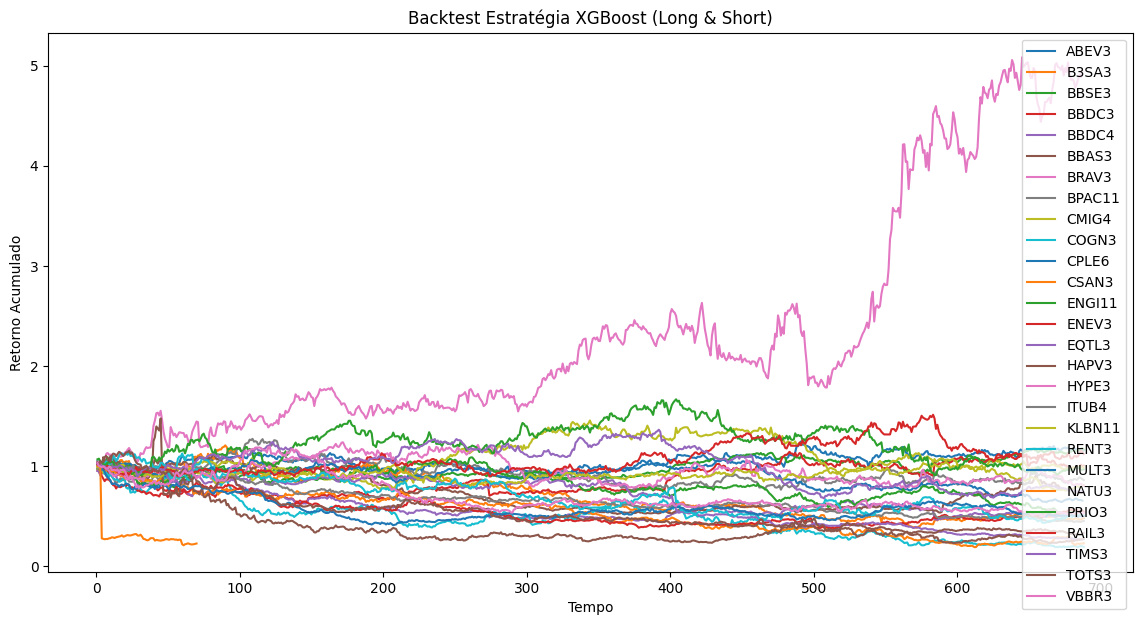

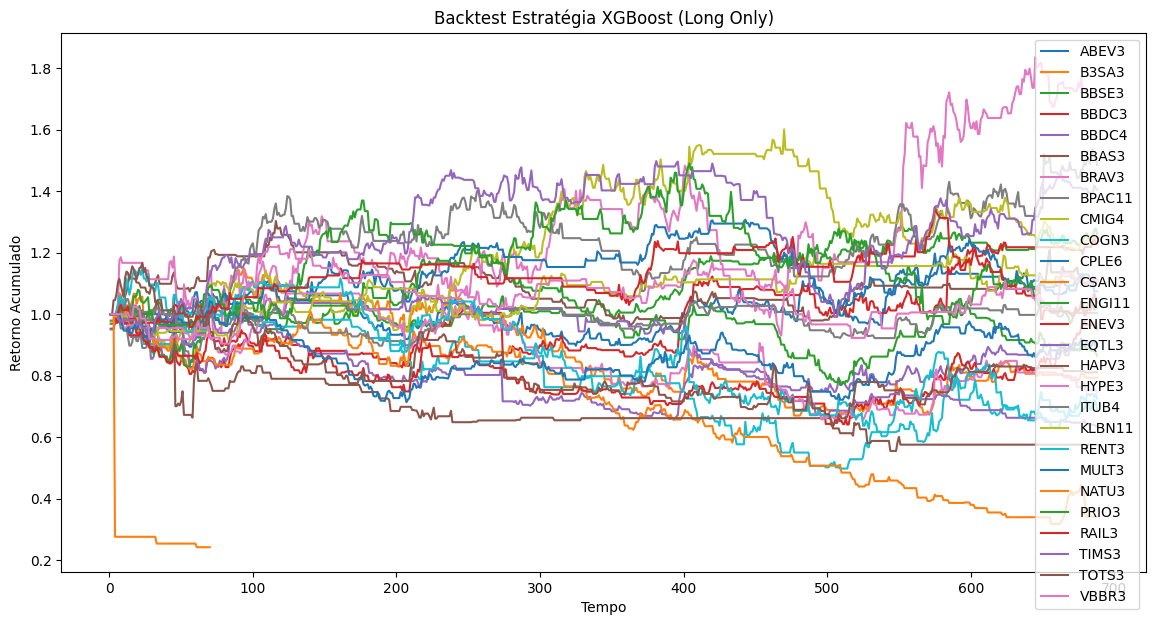

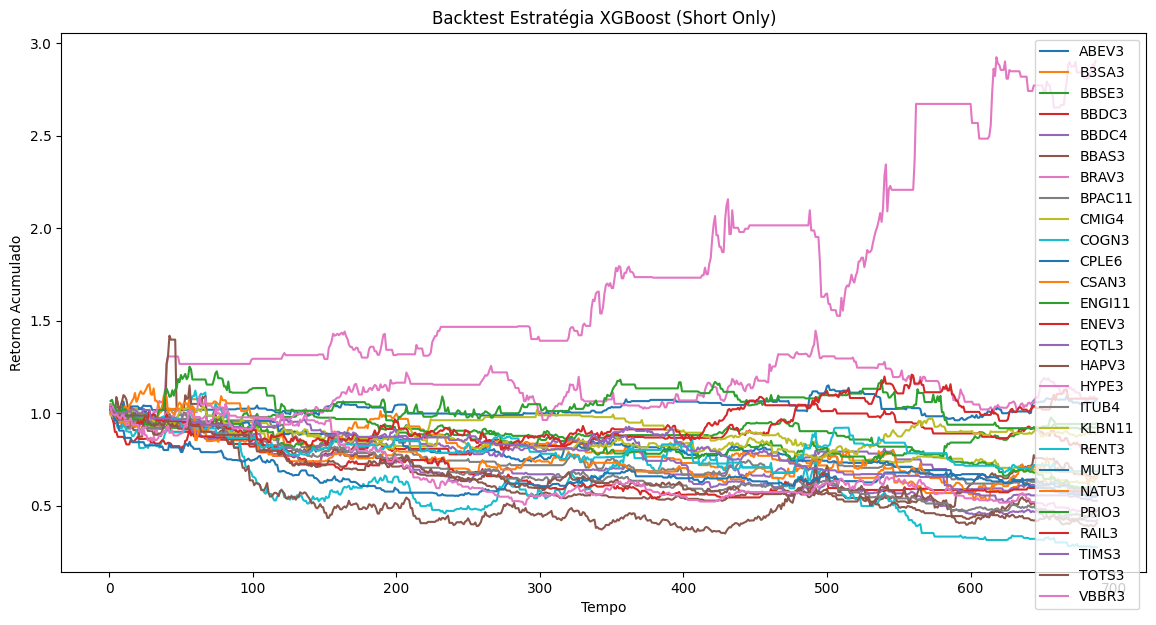

In [ ]:
# ================= Plots =================

plt.figure(figsize=(14,7))
for col in results_longshort.columns:
    plt.plot(results_longshort.index, results_longshort[col], label=col)
plt.title("Backtest Estratégia XGBoost (Long & Short)")
plt.xlabel("Tempo")
plt.ylabel("Retorno Acumulado")
plt.legend()
plt.show()

plt.figure(figsize=(14,7))
for col in results_long.columns:
    plt.plot(results_long.index, results_long[col], label=col)
plt.title("Backtest Estratégia XGBoost (Long Only)")
plt.xlabel("Tempo")
plt.ylabel("Retorno Acumulado")
plt.legend()
plt.show()

plt.figure(figsize=(14,7))
for col in results_short.columns:
    plt.plot(results_short.index, results_short[col], label=col)
plt.title("Backtest Estratégia XGBoost (Short Only)")
plt.xlabel("Tempo")
plt.ylabel("Retorno Acumulado")
plt.legend()
plt.show()


In [ ]:
import plotly.graph_objects as go

# --- Long & Short ---
fig = go.Figure()
for col in results_longshort.columns:
    fig.add_trace(go.Scatter(
        x=results_longshort.index,
        y=results_longshort[col],
        mode='lines',
        name=col
    ))
fig.update_layout(
    title="Backtest Estratégia XGBoost (Long & Short)",
    xaxis_title="Tempo",
    yaxis_title="Retorno Acumulado",
    template="plotly_dark",
    legend=dict(x=0, y=1)
)
fig.show()

# --- Long Only ---
fig = go.Figure()
for col in results_long.columns:
    fig.add_trace(go.Scatter(
        x=results_long.index,
        y=results_long[col],
        mode='lines',
        name=col
    ))
fig.update_layout(
    title="Backtest Estratégia XGBoost (Long Only)",
    xaxis_title="Tempo",
    yaxis_title="Retorno Acumulado",
    template="plotly_dark",
    legend=dict(x=0, y=1)
)
fig.show()

# --- Short Only ---
fig = go.Figure()
for col in results_short.columns:
    fig.add_trace(go.Scatter(
        x=results_short.index,
        y=results_short[col],
        mode='lines',
        name=col
    ))
fig.update_layout(
    title="Backtest Estratégia XGBoost (Short Only)",
    xaxis_title="Tempo",
    yaxis_title="Retorno Acumulado",
    template="plotly_dark",
    legend=dict(x=0, y=1)
)
fig.show()
